# Reducing Failure-Inducing Inputs

By construction, fuzzers create inputs that may be hard to read.  This causes issues during _debugging_, when a human has to analyze the exact cause of the failure.  In this chapter, we present techniques that _automatically reduce and simplify failure-inducing inputs to a minimum_ in order to ease debugging.

**Prerequisites**

* Using the "delta debugging" technique for reduction has no specific prerequisites.
* To understand the `DeltaDebugger` implementation, reading [the chapter on tracing](Tracer.ipynb) is recommended.

This chapter is adapted from [a similar chapter in "The Fuzzing Book"](https://www.fuzzingbook.org/html/Reducer.html). The material has been adapted to be independent from the `fuzzingbook` infrastructure and to provide a simpler invocation interface.

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.DeltaDebugger import <identifier>
```

and then make use of the following features.


A _reducer_ takes a failure-inducing input and reduces it to the minimum that still reproduces the failure.  This chapter provides a `DeltaDebugger` class that implements such a reducer.

Here is a simple example: An arithmetic expression causes an error in the Python interpreter:

```python
>>> def myeval(inp):
>>>     return eval(inp)
>>> with ExpectError():
>>>     myeval('1 + 2 * 3 / 0')
Traceback (most recent call last):
  File "<ipython-input-102-deae668eac94>", line 2, in <module>
    myeval('1 + 2 * 3 / 0')
  File "<ipython-input-101-e6018665ac61>", line 2, in myeval
    return eval(inp)
  File "<string>", line 1, in <module>
ZeroDivisionError: division by zero (expected)
```
Can we reduce this input to a minimum? _Delta Debugging_ is a simple and robust reduction algorithm. We provide a `DeltaDebugger` class that is used in conjunction with a (failing) function call:

```python
with DeltaDebugger() as dd:
    fun(args...)
dd
```

The class automatically determines minimal arguments that cause the function to fail with the same exception as the original. Printing out the class object reveals the minimized call.

```python
>>> with DeltaDebugger() as dd:
>>>     myeval('1 + 2 * 3 / 0')
>>> dd
myeval(inp='2/0')
```
The input is reduced to the maximum: We get the essence of the division by zero.

There also is an interface to access the reduced input(s) programmatically. The method `reduced_args()` returns a dictionary in which all function arguments are minimized:

```python
>>> dd.reduced_args()
{'inp': '2/0'}
```
And you can also access the function itself, as well as its original arguments.

```python
>>> dd.function().__name__, dd.args()
('myeval', {'inp': '1 + 2 * 3 / 0'})
```
`DelteDebugger` minimizes all arguments that support a `len()` operation and that can be indexed – notably _strings_ and _lists_. If a function has multiple arguments, all arguments that can be minimized will be minimized.



## Why Reducing?

A common problem in debugging is that given an input, only a _small part of that input may be responsible for the failure_. A central part of debugging is to _identify_ these parts – and to simplify (or _reduce_) the input to a minimal form that reproduces the failure – but does and contains as little else as possible.

Here's an example of such a situation.  We have a `mystery()` method that – given its code – can occasionally fail.  But under which circumstances does this actually happen?  We have deliberately obscured the exact condition in order to make this non-obvious.

In [1]:
import bookutils

In [2]:
import Tracer

In [3]:
from bookutils import quiz

In [4]:
def mystery(inp):
    x = inp.find(chr(0o17 + 0o31))
    y = inp.find(chr(0o27 + 0o22))
    if x >= 0 and y >= 0 and x < y:
        raise ValueError("Invalid input")
    else:
        pass

To find an input that causes the function to fail, let us _fuzz_ it – that is, feed it with random inputs – until we find a failing input. There's [entire books about fuzzing](https://fuzzingbook.org); but here, a very simple `fuzz()` function for this purpose will already suffice.

To build a fuzzer, we need random inputs – and thus a source for randomness. The function `random.randrange(a, b)` returns a random number in the range (a, b).

In [5]:
import random

In [6]:
random.randrange(32, 128)

107

We can use `random.randrange()` to compose random (printable) characters:

In [7]:
def fuzz():
    length = random.randrange(10, 70)
    fuzz = ""
    for i in range(length):
        fuzz += chr(random.randrange(32, 127))
    return fuzz

Here are some random strings produced by our `fuzz()` function:

In [8]:
for i in range(6):
    print(repr(fuzz()))

'N&+slk%hyp5'
"'@[3(rW*M5W]tMFPU4\\P@tz%[X?uo\\1?b4T;1bDeYtHx #UJ5"
'w}pMmPodJM,_%%BC~dYN6*g|Y*Ou9I<P94}7,99ivb(9`=%jJj*Y*d~OLXk!;J'
"!iOU8]hqg00?u(c);>:\\=V<ZV1=*g#UJA'No5QZ)~--[})Sdv#m*L"
'0iHh[-MzS.U.X}fG7aA:G<bEI\'Ofn[",Mx{@jfto}i3D?7%V7XdtO6BjYEa#Il)~]'
"E`h7h)ChX0G*m,|sosJ.mu/\\c'EpaPi0(n{"


Let us now use `fuzz()` to find an input where `mistery()` fails:

In [9]:
while True:
    inp = fuzz()
    try:
        mystery(inp)
    except ValueError:
        break

This is an input that causes `mystery()` to fail:

In [10]:
failing_input = inp
failing_input

'V"/+!aF-(V4EOz*+s/Q,7)2@0_'

In [11]:
from ExpectError import ExpectError

In [12]:
with ExpectError():
    mystery(failing_input)

Traceback (most recent call last):
  File "<ipython-input-12-2c6d37965be6>", line 2, in <module>
    mystery(failing_input)
  File "<ipython-input-4-26b70a4c8761>", line 5, in mystery
    raise ValueError("Invalid input")
ValueError: Invalid input (expected)


Something in this input causes `mystery()` to fail.  But what is it?

## Manual Input Reduction

One important step in the debugging process is _reduction_ – that is, to identify those circumstances of a failure that are relevant for the failure to occur, and to _omit_ (if possible) those parts that are not.  As Kernighan and Pike \cite{Kernighan1999} put it:

> For every circumstance of the problem, check whether it is relevant for the problem to occur.  If it is not, remove it from the problem report or the test case in question.

Specifically for inputs, they suggest a _divide and conquer_ process:

> Proceed by binary search.  Throw away half the input and see if the output is still wrong; if not, go back to the previous state and discard the other half of the input.

This is something we can easily try out, using our last generated input:

In [13]:
failing_input

'V"/+!aF-(V4EOz*+s/Q,7)2@0_'

For instance, we can see whether the error still occurs if we only feed in the first half:

In [14]:
half_length = len(failing_input) // 2   # // is integer division
first_half = failing_input[:half_length]
first_half

'V"/+!aF-(V4EO'

In [15]:
with ExpectError():
    mystery(first_half)

Nope – the first half alone does not suffice.  Maybe the second half?

In [16]:
second_half = failing_input[half_length:]
assert first_half + second_half == failing_input
second_half

'z*+s/Q,7)2@0_'

In [17]:
with ExpectError():
    mystery(second_half)

This did not go so well either.  We may still proceed by cutting away _smaller chunks_ – say, one character after another.  If our test is deterministic and easily repeated, it is clear that this process eventually will yield a reduced input.  But still, it is a rather inefficient process, especially for long inputs.  What we need is a _strategy_ that effectively minimizes a failure-inducing input – a strategy that can be automated.

## Delta Debugging

One strategy to effectively reduce failure-inducing inputs is _delta debugging_ \cite{Zeller2002}.  Delta Debugging implements the "binary search" strategy, as listed above, but with a twist: If neither half fails (also as above), it keeps on cutting away smaller and smaller chunks from the input, until it eliminates individual characters.  Thus, after cutting away the first half, we cut away
the first quarter, the second quarter, and so on.

Let us illustrate this on our example, and see what happens if we cut away the first quarter.

In [18]:
quarter_length = len(failing_input) // 4
input_without_first_quarter = failing_input[quarter_length:]
input_without_first_quarter

'F-(V4EOz*+s/Q,7)2@0_'

In [19]:
with ExpectError():
    mystery(input_without_first_quarter)

Traceback (most recent call last):
  File "<ipython-input-19-3405be4be6b3>", line 2, in <module>
    mystery(input_without_first_quarter)
  File "<ipython-input-4-26b70a4c8761>", line 5, in mystery
    raise ValueError("Invalid input")
ValueError: Invalid input (expected)


Ah! This has failed, and reduced our failing input by 25%.  Let's remove another quarter.

In [20]:
input_without_first_and_second_quarter = failing_input[quarter_length * 2:]
input_without_first_and_second_quarter

'Oz*+s/Q,7)2@0_'

In [21]:
with ExpectError():
    mystery(input_without_first_and_second_quarter)

This is not too surprising, as we had that one before:

In [22]:
second_half

'z*+s/Q,7)2@0_'

In [23]:
input_without_first_and_second_quarter

'Oz*+s/Q,7)2@0_'

How about removing the third quarter, then?

In [24]:
input_without_first_and_third_quarter = failing_input[quarter_length:
                                                      quarter_length * 2] + failing_input[quarter_length * 3:]
input_without_first_and_third_quarter

'F-(V4EQ,7)2@0_'

In [25]:
with ExpectError():
    mystery(input_without_first_and_third_quarter)

Traceback (most recent call last):
  File "<ipython-input-25-2736f29f5713>", line 2, in <module>
    mystery(input_without_first_and_third_quarter)
  File "<ipython-input-4-26b70a4c8761>", line 5, in mystery
    raise ValueError("Invalid input")
ValueError: Invalid input (expected)


Yes!  This has succeeded.  Our input is now 50% smaller.

We have now tried to remove pieces that make up $\frac{1}{2}$ and $\frac{1}{4}$ of the original failing string.  In the next iteration, we would go and remove even smaller pieces – $\frac{1}{8}$, $\frac{1}{16}$ and so on.  We continue until we are down to $\frac{1}{26}$ – that is, individual characters.

However, this is something we happily let a computer do for us – and this is what the _Delta Debugging_ algorithm does.  Delta Debugging implements the strategy sketched above: It first removes larger chunks of size $\frac{1}{2}$; if this does not fail, then we proceed to chunks of size $\frac{1}{4}$, then $\frac{1}{8}$ and so on.

Our `ddmin()` implementation uses almost the same Python code as Zeller in \cite{Zeller2002}; the only difference is that it has been adapted to work on Python 3.  The variable `n` (initially 2) indicates the granularity – in each step, chunks of size $\frac{1}{n}$ are cut away.  If none of the test fails (`some_complement_is_failing` is False), then `n` is doubled – until it reaches the length of the input.

In [26]:
PASS = 'PASS'
FAIL = 'FAIL'
UNRESOLVED = 'UNRESOLVED'

In [27]:
def ddmin(test, inp, *test_args):
    """Reduce the input inp, using the outcome of test(fun, inp)."""
    assert test(inp, *test_args) != PASS

    n = 2     # Initial granularity
    while len(inp) >= 2:
        start = 0
        subset_length = len(inp) / n
        some_complement_is_failing = False

        while start < len(inp):
            complement = inp[:int(start)] + \
                inp[int(start + subset_length):]

            if test(complement, *test_args) == FAIL:
                inp = complement
                n = max(n - 1, 2)
                some_complement_is_failing = True
                break

            start += subset_length

        if not some_complement_is_failing:
            if n == len(inp):
                break
            n = min(n * 2, len(inp))

    return inp

To see how `ddmin()` works, let us run it on our failing input. We need to define a `test` function that returns PASS or FAIL, depending on the test outcome. This `generic_test()` assumes that the function fails if it raises an exception (such as an `AssertException`), and passes otherwise. The optional argument `expected_exc` specifies the name of exception to be checked for; this ensures we reduce only for the kind of error raised in the original failure.

In [28]:
def generic_test(inp, fun, expected_exc=None):
    result = None
    detail = ""
    try:
        result = fun(inp)
        outcome = PASS
    except Exception as exc:
        detail = f" ({type(exc).__name__}: {str(exc)})"
        if expected_exc is None:
            outcome = FAIL
        elif type(exc) == type(expected_exc) and str(exc) == str(expected_exc):
            outcome = FAIL
        else:
            outcome = UNRESOLVED

    print(f"{fun.__name__}({repr(inp)}): {outcome}{detail}")
    return outcome

We can now invoke `ddmin()` in our setting. With each step, we see how the remaining input gets smaller and smaller, until only two characters remain:

In [29]:
ddmin(generic_test, failing_input, mystery, ValueError('Invalid input'))

mystery('V"/+!aF-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
mystery('z*+s/Q,7)2@0_'): PASS
mystery('V"/+!aF-(V4EO'): PASS
mystery('F-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
mystery('Oz*+s/Q,7)2@0_'): PASS
mystery('F-(V4E,7)2@0_'): FAIL (ValueError: Invalid input)
mystery(',7)2@0_'): PASS
mystery('F-(V4E'): PASS
mystery('V4E,7)2@0_'): PASS
mystery('F-(,7)2@0_'): FAIL (ValueError: Invalid input)
mystery(',7)2@0_'): PASS
mystery('F-(2@0_'): PASS
mystery('F-(,7)'): FAIL (ValueError: Invalid input)
mystery(',7)'): PASS
mystery('F-('): PASS
mystery('-(,7)'): FAIL (ValueError: Invalid input)
mystery('(,7)'): FAIL (ValueError: Invalid input)
mystery('7)'): PASS
mystery('(,'): PASS
mystery(',7)'): PASS
mystery('(7)'): FAIL (ValueError: Invalid input)
mystery('7)'): PASS
mystery('()'): FAIL (ValueError: Invalid input)
mystery(')'): PASS
mystery('('): PASS


'()'

Now we know why `mystery()` fails – it suffices that the input contains two matching parentheses.  Delta Debugging determines this in 25 steps.  Its result is _1-minimal_, meaning that every character contained is required to produce the error; removing any (as seen in the last two tests, above) no longer makes the test fail.  This property is guaranteed by the delta debugging algorithm, which in its last stage always tries to delete characters one by one.

A reduced test case such as the one above has many advantages:

* A reduced test case __reduces the _cognitive load_ of the programmer__.  The test case is shorter and focused, and thus does not burden the programmer with irrelevant details.  A reduced input typically leads to shorter executions and smaller program states, both of which reduce the search space as it comes to understanding the bug.  In our case, we have eliminated lots of irrelevant input – only the two characters the reduced input contains are relevant.

* A reduced test case __is easier to communicate__.  All one needs here is the summary: `mystery() fails on "()"`, which is much better than `mystery() fails on a 4100-character input (attached)`.

* A reduced test case helps in __identifying duplicates__.  If similar bugs have been reported already, and all of them have been reduced to the same cause (namely that the input contains matching parentheses), then it becomes obvious that all these bugs are different symptoms of the same underlying cause – and would all be resolved at once with one code fix.

How effective is delta debugging?  In the best case (when the left half or the right half fails), the number of tests is logarithmic proportional to the length $n$ of an input (i.e., $O(\log_2 n)$); this is the same complexity as binary search.  In the worst case, though, delta debugging can require a number of tests proportional to $n^2$  (i.e., $O(n^2)$) – this happens in the case when we are down to character granularity, and we have to repeatedly tried to delete all characters, only to find that deleting the last character results in a failure \cite{Zeller2002}.  (This is a pretty pathological situation, though.)

In general, delta debugging is a robust algorithm that is easy to implement, easy to deploy, and easy to use – provided that the underlying test case is deterministic and runs quickly enough to warrant a number of experiments. In general, any debugging task should start with simplifying the test case as much as possible – and this is where delta debugging can help.

## A Simple DeltaDebugger Interface

As defined above, using `ddmin()` still requires the developer to set up a special testing function – and writing or using even a generic tester (like `generic_test()`) takes some effort.  We want to simplify the setup such that only a single line of Python is required.

Our aim is to have a `DeltaDebugger` class that we can use in conjunction with a failing (i.e., exception raising) function call:

```python
with DeltaDebugger() as dd:
    mystery(failing_input)
```
Here, at the end of the `with` statement, printing out `dd` shows us the minimal input that causes the failure.

### Excursion: Implementing DeltaDebugger

Our interface consist of three building blocks:

* First, we collect the name and args of the first call in the `with` body, as well as the exception it raises.
* Second, we set up an infrastructure such that we can repeat calls with different arguments.
* Third, we create a `DeltaDebugger` class that implements the `ddmin()` algorithm.

#### Collecting a Call

We start by creating an infrastructure that collects a call. The `CallCollector` class saves the first call observed in `_function`, `_args`, and `_exception` attributes, respectively; it then turns tracing off.

In [30]:
import sys

In [31]:
from types import FunctionType

In [32]:
class CallCollector(object):
    """Collect an exception-raising function call f().
    Use as `with CallCollector(): f()`"""

    def __init__(self):
        """Initialize collector"""
        self._function = None
        self._args = None
        self._exception = None

    def traceit(self, frame, event, arg):
        """Tracing function. Collect first call, then turn tracing off."""
        if event == 'call':
            name = frame.f_code.co_name
            if name.startswith('__'):
                # Internal function
                return

            if self._function is None:
                self._function = FunctionType(frame.f_code,
                                              globals=globals(),
                                              name=name)
                self._args = {}  # Create a local copy
                for var in frame.f_locals:
                    self._args[var] = frame.f_locals[var]

            # Turn tracing off
            sys.settrace(self.original_trace_function)

    def diagnosis(self):
        """Produce a diagnosis. To be defined in subclasses."""
        pass

    def args(self):
        """Return the dictionary of collected arguments."""
        return self._args

    def function(self):
        """Return the function called."""
        return self._function

    def __enter__(self):
        """Called at begin of `with` block. Turn tracing on."""
        self.original_trace_function = sys.gettrace()
        sys.settrace(self.traceit)
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        """Called at end of `with` block. Turn tracing off."""
        sys.settrace(self.original_trace_function)
        if self._function is None:
            return False  # Re-raise exception, if any

        self._exception = exc_value
        self.diagnosis()
        return True  # Ignore exception

Here are the attributes as collected by `CallCollector` for our `mystery()` function:

In [33]:
with CallCollector() as call_collector:
    mystery(failing_input)

In [34]:
call_collector._function

<function __main__.mystery(inp)>

In [35]:
call_collector._args

{'inp': 'V"/+!aF-(V4EOz*+s/Q,7)2@0_'}

In [36]:
call_collector._exception

ValueError('Invalid input')

If an error occurs _before_ the first function call takes place, the exception is simply re-raised.

In [37]:
with ExpectError():
    with CallCollector() as c:
        some_error()

Traceback (most recent call last):
  File "<ipython-input-37-b5516efdadd0>", line 3, in <module>
    some_error()
NameError: name 'some_error' is not defined (expected)


#### Repeating a Call

Our second step is an infrastructure such that we can call the function collected earlier with alternate arguments. We can call the function directly via the collected `_function` attribute:

In [38]:
with ExpectError():
    call_collector._function("foo")

In [39]:
with ExpectError():
    call_collector._function(failing_input)

Traceback (most recent call last):
  File "<ipython-input-39-8b3b221fbbf8>", line 2, in <module>
    call_collector._function(failing_input)
  File "<ipython-input-4-26b70a4c8761>", line 5, in mystery
    raise ValueError("Invalid input")
ValueError: Invalid input (expected)


We can also provide the arguments collected during the call:

In [40]:
with ExpectError():
    call_collector._function(**call_collector._args)

Traceback (most recent call last):
  File "<ipython-input-40-7f654363de6a>", line 2, in <module>
    call_collector._function(**call_collector._args)
  File "<ipython-input-4-26b70a4c8761>", line 5, in mystery
    raise ValueError("Invalid input")
ValueError: Invalid input (expected)


Our `call()` method calls the collected function using this construct. It also allows to _change_ individual arguments by providing a `new_args` dictionary of variable names to new values.

In [41]:
class CallCollector(CallCollector):
    def call(self, new_args={}):
        """Call collected function. If new_args is given,
        override arguments from its {var: value} entries."""
        args = {}  # Create local copy
        for var in self._args:
            args[var] = self._args[var]
        for var in new_args:
            args[var] = new_args[var]

        return self._function(**new_args)

Using simply `call()` without arguments reproduces the failure:

In [42]:
with CallCollector() as call_collector:
    mystery(failing_input)
with ExpectError():
    call_collector.call()

Traceback (most recent call last):
  File "<ipython-input-42-9d0c034c39c2>", line 4, in <module>
    call_collector.call()
  File "<ipython-input-41-583587930c35>", line 11, in call
    return self._function(**new_args)
TypeError: mystery() missing 1 required positional argument: 'inp' (expected)


We can also supply alternate arguments (and get alternate outcomes):

In [43]:
with ExpectError():
    call_collector.call({'inp': 'foo'})

#### Testing, Logging, and Caching

Our next to last step is an infrastructure that implements delta debugging for the collected call.

We first introduce a `CallReducer` class as an abstract superclass for all kinds of reducers.
Its `run()` method tests the function and returns PASS, FAIL, or UNRESOLVED. As with `generic_test()`, above, we check for exception type and exact error message.

In [44]:
class CallReducer(CallCollector):
    def __init__(self, log=False):
        """Initialize. If log is True, enable logging."""
        super().__init__()
        self.log = log
        self.reset()

    def reset(self):
        """Reset the number of tests."""
        self.tests = 0

    def run(self, args):
        """Run collected function with args. Return
        * PASS if no exception occurred
        * FAIL if the collected exception occurred
        * UNRESOLVED if some other exception occurred.
        Not to be used directly; can be overloaded in subclasses.
        """
        try:
            result = self.call(args)
        except Exception as exc:
            self.last_exception = exc
            if (type(exc) == type(self._exception) and
                    str(exc) == str(self._exception)):
                return FAIL
            else:
                return UNRESOLVED  # Some other failure

        self.last_result = result
        return PASS

The `test()` method runs a single test (with logging, if wanted); the `reduce_arg()` method will eventually reduce an input to the minimum.

In [45]:
class CallReducer(CallReducer):
    def format_call(self, args=None):
        """Return a string representing a call of the function with given args."""
        if args is None:
            args = self._args
        return self._function.__name__ + "(" + \
            ", ".join(f"{arg}={repr(args[arg])}" for arg in args) + ")"

    def format_exception(self, exc):
        """Return a string representing the given exception."""
        s = type(exc).__name__
        if str(exc):
            s += ": " + str(exc)
        return s

    def test(self, args):
        """Like run(), but also log detail and keep statistics."""
        outcome = self.run(args)
        if outcome == PASS:
            detail = ""
        else:
            detail = f" ({self.format_exception(self.last_exception)})"

        self.tests += 1
        if self.log:
            print(f"Test #{self.tests} {self.format_call(args)}: {outcome}{detail}")

        return outcome

    def reduce_arg(self, var_to_be_reduced, args):
        """Determine and return a minimal value for var_to_be_reduced.
        To be overloaded in subclasses."""
        return args[var_to_be_reduced]

Here's some logging output from the `test()` function:

In [46]:
with CallReducer(log=True) as reducer:
    mystery(failing_input)

reducer.test({'inp': failing_input})
reducer.test({'inp': '123'})
reducer.test({'inp': '123'})

Test #1 mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Test #2 mystery(inp='123'): PASS
Test #3 mystery(inp='123'): PASS


'PASS'

The `CachingCallReducer` variant saves test results, such that we don't have to run the same tests again and again:

In [47]:
class CachingCallReducer(CallReducer):
    """Like CallReducer, but cache test outcomes."""
    def reset(self):
        super().reset()
        self._cache = {}

    def test(self, args):
        # Create a hashable index
        try:
            index = frozenset((k, v) for k, v in args.items())
        except TypeError:
            # Non-hashable value – do not use cache
            return super().test(args)

        if index in self._cache:
            return self._cache[index]

        outcome = super().test(args)
        self._cache[index] = outcome

        return outcome

If we now repeat a test with the same argument, its outcome can be found in the cache:

In [48]:
with CachingCallReducer(log=True) as reducer:
    mystery(failing_input)

reducer.test({'inp': failing_input})
reducer.test({'inp': '123'})
reducer.test({'inp': '123'})

Test #1 mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Test #2 mystery(inp='123'): PASS


'PASS'

#### Reducing Arguments

The `DeltaDebugger` class finally implements the `ddmin` algorithm on the arguments of our collected call. Its `reduce_arg()` method is the same as `ddmin()`, above, except that it is applied on one of multiple function arguments.

In [49]:
class DeltaDebugger(CachingCallReducer):
    def __init__(self, **args):
        super().__init__(**args)
        self._reduced_args = None

    def reduce_arg(self, var_to_be_reduced, args):
        inp = args[var_to_be_reduced]

        n = 2     # Initial granularity
        while len(inp) >= 2:
            start = 0
            subset_length = len(inp) / n
            some_complement_is_failing = False

            while start < len(inp):
                complement = inp[:int(start)] + \
                    inp[int(start + subset_length):]

                new_args = {}  # Create copy
                for var in args:
                    new_args[var] = args[var]
                new_args[var_to_be_reduced] = complement
                if self.test(new_args) == FAIL:
                    inp = complement
                    n = max(n - 1, 2)
                    some_complement_is_failing = True
                    break

                start += subset_length

            if not some_complement_is_failing:
                if n == len(inp):
                    break
                n = min(n * 2, len(inp))

        return inp

What happens if a function has multiple arguments? First, we check if they are _reducible_ – that is, they provide a `len()` length function and a way to access indexed elements. This holds for all strings and all lists, as well as other ordered collections.

In [50]:
class DeltaDebugger(DeltaDebugger):
    def reducible(self, arg):
        """Return true if arg supports len() and indexing."""
        try:
            x = len(arg)
        except TypeError:
            return False

        try:
            x = arg[0]
        except TypeError:
            return False
        except IndexError:
            return False

        return True

Our method `reduce_args()` reduces recorded call arguments, one after the one, until all are reduced to a 1-minimum. Reducing them individually (rather than, say, all at once) allows to maintain a stable _context_ during reduction.

In [51]:
class FailureNotReproducedError(ValueError):
    pass

class NotFailingError(ValueError):
    pass

class NoCallError(ValueError):
    pass

In [52]:
class DeltaDebugger(DeltaDebugger):
    def check_reproducibility(self):
        """Check whether running the function again fails"""
        self.reset()
        outcome = self.test(self._args)
        if outcome == UNRESOLVED:
            raise FailureNotReproducedError(
                "When called again, " +
                self.format_call(self._args) + 
                " raised " +
                self.format_exception(self.last_exception) +
                " instead of " +
                self.format_exception(self._exception))

        if outcome == PASS:
            raise NotFailingError("When called again, " +
                                  self.format_call(self._args) + 
                                  " did not fail")
        assert outcome == FAIL

In [53]:
class DeltaDebugger(DeltaDebugger):
    def reduce_args(self):
        """Reduce all reducible arguments, using reduce_arg(). Can be overloaded in subclasses"""
        args = {}  # Local copy
        for var in self._args:
            args[var] = self._args[var]
        vars_to_be_reduced = set(args.keys())

        self.check_reproducibility()

        # We take turns in reducing variables until all are processed
        while len(vars_to_be_reduced) > 0:
            for var in vars_to_be_reduced:
                value = args[var]
                if not self.reducible(value):
                    vars_to_be_reduced.remove(var)
                    break

                if self.log:
                    print(f"Reducing {var}...")

                reduced_value = self.reduce_arg(var, args)
                if len(reduced_value) < len(value):
                    args[var] = reduced_value
                    if self.log:
                        print(f"Reduced {var} to {repr(reduced_value)}")
                    vars_to_be_reduced = set(args.keys())

                vars_to_be_reduced.remove(var)
                break

        assert self.test(args) == FAIL, f"{self.format_call(args)} does not fail"
        if self.log:
            print(f"Reduced call to {self.format_call(args)}")

        self._reduced_args = args

We define the `diagnosis()` method that will be invoked at the end of the `with` block. It checks for a number of preconditions and then invokes the reducer.

In [54]:
class DeltaDebugger(DeltaDebugger):
    def diagnosis(self):
        if self._function is None:
            raise NoCallError("No function call observed")
        if self._exception is None:
            raise NotFailingError(f"{self.format_call()} did not raise an exception")

        if self.log:
            print(f"Observed {self.format_call()} raising {self.format_exception(self._exception)}")

        self.reduce_args()

We finish the implementation with two methods that allow users to access the diagnostics. `reduced_args()` returns the dictionary of reduced arguments.
The `__repr__()` method returns a string representation of the reduced call.

In [55]:
class DeltaDebugger(DeltaDebugger):
    def reduced_args(self):
        """Return the dictionary {var: value} of reduced arguments."""
        return self._reduced_args

    def __repr__(self):
        return self.format_call(self.reduced_args())

### End of Excursion

To see how the `DeltaDebugger` works, let us run it on our failing input. The expected usage is as introduced earlier – we wrap the failing function in a `with` block, and then print out the debugger to see the reduced arguments. We see that `DeltaDebugger` easily reduces the arguments to the minimal failure-inducing input:

In [56]:
with DeltaDebugger() as dd:
    mystery(failing_input)
dd

mystery(inp='()')

We can turn on logging for `DeltaDebugger` to see how it proceeds. With each step, we see how the remaining input gets smaller and smaller, until only two characters remain:

In [57]:
with DeltaDebugger(log=True) as dd:
    mystery(failing_input)
dd

Observed mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_') raising ValueError: Invalid input
Test #1 mystery(inp='V"/+!aF-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Reducing inp...
Test #2 mystery(inp='z*+s/Q,7)2@0_'): PASS
Test #3 mystery(inp='V"/+!aF-(V4EO'): PASS
Test #4 mystery(inp='F-(V4EOz*+s/Q,7)2@0_'): FAIL (ValueError: Invalid input)
Test #5 mystery(inp='Oz*+s/Q,7)2@0_'): PASS
Test #6 mystery(inp='F-(V4E,7)2@0_'): FAIL (ValueError: Invalid input)
Test #7 mystery(inp=',7)2@0_'): PASS
Test #8 mystery(inp='F-(V4E'): PASS
Test #9 mystery(inp='V4E,7)2@0_'): PASS
Test #10 mystery(inp='F-(,7)2@0_'): FAIL (ValueError: Invalid input)
Test #11 mystery(inp='F-(2@0_'): PASS
Test #12 mystery(inp='F-(,7)'): FAIL (ValueError: Invalid input)
Test #13 mystery(inp=',7)'): PASS
Test #14 mystery(inp='F-('): PASS
Test #15 mystery(inp='-(,7)'): FAIL (ValueError: Invalid input)
Test #16 mystery(inp='(,7)'): FAIL (ValueError: Invalid input)
Test #17 mystery(inp='7)'): PASS
Test #18 mystery(inp='(

mystery(inp='()')

It is also possible to access the debugger programmatically:

In [58]:
with DeltaDebugger() as dd:
    mystery(failing_input)

In [59]:
dd.args()

{'inp': 'V"/+!aF-(V4EOz*+s/Q,7)2@0_'}

In [60]:
dd.reduced_args()

{'inp': '()'}

## Usage Examples

Let us apply `DeltaDebugger` on a number of examples. 

### Reducing remove_html_markup()

For our ongoing `remove_html_markup()` example, we can reduce the failure-inducing input to a minimum, too:

In [61]:
from Assertions import remove_html_markup

In [62]:
with DeltaDebugger(log=True):
    remove_html_markup('"x > y"')

Observed remove_html_markup(s='"x > y"') raising AssertionError
Test #1 remove_html_markup(s='"x > y"'): FAIL (AssertionError)
Reducing s...
Test #2 remove_html_markup(s='> y"'): PASS
Test #3 remove_html_markup(s='"x '): PASS
Test #4 remove_html_markup(s='x > y"'): PASS
Test #5 remove_html_markup(s='"> y"'): FAIL (AssertionError)
Test #6 remove_html_markup(s='"y"'): PASS
Test #7 remove_html_markup(s='"> '): FAIL (AssertionError)
Test #8 remove_html_markup(s='> '): PASS
Test #9 remove_html_markup(s='"'): PASS
Test #10 remove_html_markup(s='" '): PASS
Test #11 remove_html_markup(s='">'): FAIL (AssertionError)
Test #12 remove_html_markup(s='>'): PASS
Reduced s to '">'
Reduced call to remove_html_markup(s='">')


### Reducing Multiple Arguments

If a function has multiple reducible variables, they get reduced in turns. This `string_error()` function fails whenever `s1` is a substring of `s2`:

In [63]:
def string_error(s1, s2):
    assert s1 not in s2, "no substrings"

In [64]:
with DeltaDebugger(log=True) as dd:
    string_error("foo", "foobar")

Observed string_error(s2='foobar', s1='foo') raising AssertionError: no substrings
Test #1 string_error(s2='foobar', s1='foo'): FAIL (AssertionError: no substrings)
Reducing s2...
Test #2 string_error(s2='bar', s1='foo'): PASS
Test #3 string_error(s2='foo', s1='foo'): FAIL (AssertionError: no substrings)
Test #4 string_error(s2='oo', s1='foo'): PASS
Test #5 string_error(s2='f', s1='foo'): PASS
Test #6 string_error(s2='fo', s1='foo'): PASS
Reduced s2 to 'foo'
Reducing s1...
Test #7 string_error(s2='foo', s1='oo'): FAIL (AssertionError: no substrings)
Test #8 string_error(s2='foo', s1='o'): FAIL (AssertionError: no substrings)
Reduced s1 to 'o'
Reducing s2...
Test #9 string_error(s2='oo', s1='o'): FAIL (AssertionError: no substrings)
Test #10 string_error(s2='o', s1='o'): FAIL (AssertionError: no substrings)
Reduced s2 to 'o'
Reducing s1...
Reduced call to string_error(s2='o', s1='o')


We see that the failure also occurs if both variables contain only one (same) character:

In [65]:
args = dd.reduced_args()
args

{'s2': 'o', 's1': 'o'}

In [66]:
with ExpectError():
    string_error(args['s1'], args['s2'])

Traceback (most recent call last):
  File "<ipython-input-66-2a031321095d>", line 2, in <module>
    string_error(args['s1'], args['s2'])
  File "<ipython-input-63-bbb028ab5242>", line 2, in string_error
    assert s1 not in s2, "no substrings"
AssertionError: no substrings (expected)


Python provides a simple way to turn dictionaries into function calls. The construct

```python
fun(**args)
```

invokes the function `fun`, with all parameters assigned from the respective values in the dictionary.
You can use this shortcut to invoke an [interactive debugger](Debugger) on the minimized input:

In [67]:
from Debugger import Debugger

In [68]:
from bookutils import next_inputs

In [69]:
# ignore
next_inputs(['print', 'quit'])

['print', 'quit']

In [70]:
with ExpectError():
    with Debugger():
        string_error(**args)

Calling string_error(s2 = 'o', s1 = 'o')


s2 = 'o'
s1 = 'o'


Traceback (most recent call last):
  File "<ipython-input-70-fa7c01311105>", line 3, in <module>
    string_error(**args)
  File "<ipython-input-63-bbb028ab5242>", line 2, in string_error
    assert s1 not in s2, "no substrings"
AssertionError: no substrings (expected)


### Reducing other Collections

Our `DeltaDebugger` is not limited to strings. It can reduce any argument `x` for which a `len(x)` operation and an indexing operation `x[i]` is defined – notably lists. Here is how to apply `DeltaDebugger` on a list:

In [71]:
def list_error(l1, l2, maxlen):
    assert len(l1) < len(l2) < maxlen, "invalid string length"

In [72]:
with DeltaDebugger() as dd:
    list_error(l1=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], l2=[1, 2, 3], maxlen=5)
dd

list_error(maxlen=5, l2=[3], l1=[10])

## Reducing Program Code

One particularly fun application of reducers is on _program code_. Technically speaking, program code is just another input to a computation; and we can actually automatically determine which minimum of program code is required to produce a failure, using Delta Debugging.

As an example, let us apply Delta Debugging on the code from [the chapter on assertions](Assertions.html). You do not need to have read the chapter; the important part is that this chapter provides an implementation of `remove_html_markup()` that we want to use.

In [73]:
# ignore
try:
    del remove_html_markup
except NameError:
    pass

In [74]:
import Assertions  # minor dependency

Here is the source code of all the chapter; this is several hundred lines long.

In [75]:
import inspect

In [76]:
assertions_source_lines, _ = inspect.getsourcelines(Assertions)
# print_content("".join(assertions_source_lines), ".py")
assertions_source_lines[:10]

['from bookutils import YouTubeVideo\n',
 'YouTubeVideo("9mI9sbKFkwU")\n',
 '\n',
 'import bookutils\n',
 '\n',
 'from bookutils import quiz\n',
 '\n',
 'import Tracer\n',
 '\n',
 'from ExpectError import ExpectError\n']

In [77]:
len(assertions_source_lines)

436

We can take this code and execute it. Nothing particular should happen here, as our imports only import definitions of functions, classes, and global variables.

In [78]:
def compile_and_run(lines):
    exec("".join(lines), {}, {})

In [79]:
compile_and_run(assertions_source_lines)

Let us add some code to it – a "My Test" assertion that tests that `remove_html_markup()`, applied on a string with double quotes, should keep these in place:

In [80]:
def compile_and_test_html_markup(lines):
    compile_and_run(lines + 
                    ['''\nassert remove_html_markup('"foo"') == '"foo"', "My Test"\n'''])

This assertion fails. (As always, `remove_html_markup()` is buggy.)

In [81]:
with ExpectError():
    compile_and_test_html_markup(assertions_source_lines)

Traceback (most recent call last):
  File "<ipython-input-81-d8f2cd9b0296>", line 2, in <module>
    compile_and_test_html_markup(assertions_source_lines)
  File "<ipython-input-80-4dd51a254e40>", line 3, in compile_and_test_html_markup
    ['''\nassert remove_html_markup('"foo"') == '"foo"', "My Test"\n'''])
  File "<ipython-input-78-bf194b6c0f8d>", line 2, in compile_and_run
    exec("".join(lines), {}, {})
  File "<string>", line 438, in <module>
AssertionError: My Test (expected)


The question we want to address in this section is: Given this assertion, can we automatically determine which part of the `Assertions` code lines in `assertions_source_lines` is relevant for producing the failure?

### Reducing Code Lines

Since our `Assertions` source code comes as a list of lines, we can apply our `DeltaDebugger` on it. The result will be the list of source lines that is necessary to make the assertion fail.

In [82]:
quiz("What will the reduced set of lines contain?",
     [
         "All of the source code in the assertions chapter.",
         "Only the source code of <samp>remove_html_markup()</samp>",
         "Only a subset of <samp>remove_html_markup()</samp>",
         "No lines at all."
     ], [x for x in range((1 + 1) ** (1 + 1)) if x % (1 + 1) == 1][1])

Let us see what the `DeltaDebugger` produces.

In [83]:
with DeltaDebugger(log=False) as dd:
    compile_and_test_html_markup(assertions_source_lines)

We get exactly _two_ lines of code:

In [84]:
reduced_lines = dd.reduced_args()['lines']
len(reduced_lines)

4

And these are:

In [85]:
from bookutils import print_content

In [86]:
print_content("".join(reduced_lines), ".py")

def square_root(x):
    return out
def remove_html_markup(s):
    tag = False

This may come as a surprise – `remove_html_markup()` is reduced to a function which does nothing – not even return a value. However, this is how it causes our "My Test" assertion to fail: In Python, a function without an explicit `return` statement returns `None`. This value is definitely not the string the "My Test" assertion expects, so it fails.

To ensure we do not remove code that actually would be necessary for normal behavior, let us add another check – one that checks for the _normal_ functionality of `remove_html_markup()`. If this one fails (say, after the code has been tampered with too much), it raises an exception – but a _different_ one from the original failure:

In [87]:
def compile_and_test_html_markup(lines):
    compile_and_run(lines +
        [
            '''if remove_html_markup('<foo>bar</foo>') != 'bar':\n''',
            '''    raise RuntimeError("Missing functionality")\n''',
            '''assert remove_html_markup('"foo"') == '"foo"', "My Test"\n'''
        ])

On our "reduced" code, we now obtain a `RuntimeError` – a different exception.

In [88]:
with ExpectError():
    compile_and_test_html_markup(dd.reduced_args()['lines'])

Traceback (most recent call last):
  File "<ipython-input-88-ffa6ade91b22>", line 2, in <module>
    compile_and_test_html_markup(dd.reduced_args()['lines'])
  File "<ipython-input-87-123bdd50db7f>", line 6, in compile_and_test_html_markup
    '''assert remove_html_markup('"foo"') == '"foo"', "My Test"\n'''
  File "<ipython-input-78-bf194b6c0f8d>", line 2, in compile_and_run
    exec("".join(lines), {}, {})
  File "<string>", line 6, in <module>
RuntimeError: Missing functionality (expected)


Such an outcome that is different from the original failure causes our `DeltaDebugger` not treating this as a failure, but rather as a `UNRESOLVED` outcome, indicating that the test cannot determine whether it passed or failed. The `ddmin` algorithm treats such unresolved outcomes as if they were passing; hence, the algorithm treats its minimization attempt as unsuccessful.

How does this change things? When we reduce the `Assertions` source code with the extended assertions, we now get a different result:

In [89]:
with DeltaDebugger(log=False) as dd:
    compile_and_test_html_markup(assertions_source_lines)
reduced_assertions_source_lines = dd.reduced_args()['lines']

Our result actually is the source code of `remove_html_markup()` – and _only_ the source code. This is a success, as Delta Debugging has eliminated all the other parts of the `Assertions` source code; these neither contribute to the correct functioning of `remove_html_markup()`, nor to the failure at hand.

In [90]:
print_content("".join(reduced_assertions_source_lines), ".py")

def remove_html_markup(s):
    tag = False
    quote = False
    out = ""
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

All in all, we have reduced the number of relevant lines in `Assertions` to about 3% of the original source code.

In [91]:
len(reduced_assertions_source_lines) / len(assertions_source_lines)

0.03211009174311927

The astute reader may notice that `remove_html_markup()`, as shown above, is slightly different from the original version in the [chapter on assertions](Assertions.ipynb). Here's the original version for comparison:

In [92]:
remove_html_markup_source_lines, _ = inspect.getsourcelines(Assertions.remove_html_markup)
print_content("".join(remove_html_markup_source_lines), ".py")

def remove_html_markup(s):
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    # postcondition
    assert '<' not in out and '>' not in out

    return out

In [93]:
quiz("In the reduced version, what has changed?",
    [
        "Comments are deleted",
        "Blank lines are deleted",
        "Initializations are deleted",
        "The assertion is deleted",
    ], [(1 ** 0 - -1 ** 0) ** n for n in range(0, 3)]
    )

Indeed, Delta Debugging has determined all these as being irrelevant for reproducing the failure – and consequently, has deleted them.

### Reducing Code Characters

We can reduce the code further by removing individual _characters_ rather than lines. To this end, we convert our (already reduced) `remove_html_markup()` code into a list of characters.

In [94]:
reduced_assertions_source_characters = list("".join(reduced_assertions_source_lines))
print(reduced_assertions_source_characters[:30])

['d', 'e', 'f', ' ', 'r', 'e', 'm', 'o', 'v', 'e', '_', 'h', 't', 'm', 'l', '_', 'm', 'a', 'r', 'k', 'u', 'p', '(', 's', ')', ':', '\n', ' ', ' ', ' ']


Our `compile_and_ttest_html_markup()` works (and fails) as before: It still joins the given strings into one and executes them. (Remember that in Python, "characters" are simply strings of length one.)

In [95]:
with ExpectError():
    compile_and_test_html_markup(reduced_assertions_source_characters)

Traceback (most recent call last):
  File "<ipython-input-95-b2a0dac71e7c>", line 2, in <module>
    compile_and_test_html_markup(reduced_assertions_source_characters)
  File "<ipython-input-87-123bdd50db7f>", line 6, in compile_and_test_html_markup
    '''assert remove_html_markup('"foo"') == '"foo"', "My Test"\n'''
  File "<ipython-input-78-bf194b6c0f8d>", line 2, in compile_and_run
    exec("".join(lines), {}, {})
  File "<string>", line 17, in <module>
AssertionError: My Test (expected)


Let's see what Delta Debugging makes of that – and also, how long it takes. The `Timer` class gives us a simple means to measure time.

In [96]:
from Timer import Timer

In [97]:
with Timer() as t:
    with DeltaDebugger(log=False) as dd:
        compile_and_test_html_markup(reduced_assertions_source_characters)

Here's the reduced result:

In [98]:
further_reduced_assertions_source_characters = dd.reduced_args()['lines']
print_content("".join(further_reduced_assertions_source_characters), ".py")

def remove_html_markup(s):
    tag=quote=False
    out=""
    for c in s:
        if c=='<'and not quote:tag=True
        if c=='>'and not quote:tag=False
        elif c=='"'or c==""and t:not quote
        elif not tag:out=out+c
    return out

There's a number of observations we can make about this code.

* All superfluous blanks and even newlines have been removed.
* As a curiosity, the initialization of `tag` and `quote` to `False` is now merged into a single (semantics-preserving) statement.
* The semantics and effect of `<` and `>` characters is preserved, as mandated by our `RuntimeError` check.
* The condition `c=="" and t` references a non-existing variable `t`, but this is never evaluated as `c` always holds one character.
* Double quotes still have the effect of not being included in the returned value: the remaining `not quote` has no effect.

Semantics-wise, this reduced variant still yields the "original" failure; the biggest semantic differences, though, are in the condition and code associated with double quotes – which actually also is the location of the defect to be fixed. This is how reducing code can also point to not only necessary, but also defective locations.

Mind you that reducing code is not cheap, and especially not if you remove by characters. It has taken `DeltaDebugger` several thousand tests to obtain the result above:

In [99]:
dd.tests

6057

And to do so, it required almost _one second_. This may be little for a human, but from a CPU standpoint, this is an enormous effort.

In [100]:
t.elapsed_time()

0.29017238604137674

In the exercises, we will discuss more efficient means to reduce code – notably by reducing at a _syntactic_ rather than a _textual_ level. Stay tuned!

## Synopsis

A _reducer_ takes a failure-inducing input and reduces it to the minimum that still reproduces the failure.  This chapter provides a `DeltaDebugger` class that implements such a reducer.

Here is a simple example: An arithmetic expression causes an error in the Python interpreter:

In [101]:
def myeval(inp):
    return eval(inp)

In [102]:
with ExpectError():
    myeval('1 + 2 * 3 / 0')

Traceback (most recent call last):
  File "<ipython-input-102-deae668eac94>", line 2, in <module>
    myeval('1 + 2 * 3 / 0')
  File "<ipython-input-101-e6018665ac61>", line 2, in myeval
    return eval(inp)
  File "<string>", line 1, in <module>
ZeroDivisionError: division by zero (expected)


Can we reduce this input to a minimum? _Delta Debugging_ is a simple and robust reduction algorithm. We provide a `DeltaDebugger` class that is used in conjunction with a (failing) function call:

```python
with DeltaDebugger() as dd:
    fun(args...)
dd
```

The class automatically determines minimal arguments that cause the function to fail with the same exception as the original. Printing out the class object reveals the minimized call.

In [103]:
with DeltaDebugger() as dd:
    myeval('1 + 2 * 3 / 0')
dd

myeval(inp='2/0')

The input is reduced to the maximum: We get the essence of the division by zero.

There also is an interface to access the reduced input(s) programmatically. The method `reduced_args()` returns a dictionary in which all function arguments are minimized:

In [104]:
dd.reduced_args()

{'inp': '2/0'}

And you can also access the function itself, as well as its original arguments.

In [105]:
dd.function().__name__, dd.args()

('myeval', {'inp': '1 + 2 * 3 / 0'})

`DelteDebugger` minimizes all arguments that support a `len()` operation and that can be indexed – notably _strings_ and _lists_. If a function has multiple arguments, all arguments that can be minimized will be minimized.

## Lessons Learned

* Reducing failure-inducing inputs to a minimum is helpful for testing and debugging.
* _Delta debugging_ is a simple and robust algorithm to easily reduce inputs of test cases, as well as their code.
* Precisely specifying failure conditions helps avoiding false diagnoses.

## Next Steps

Our next chapter focuses on finding _failure-inducing code changes_, again involving delta debugging.

## Background

The "lexical" delta debugging algorithm discussed here stems from \cite{Zeller2002}; actually, this is the exact Python implementation as used by Zeller in 2002.  The idea of systematically reducing inputs has been discovered a number of times, although not as  automatic and generic as delta debugging. \cite{Slutz1998}, for instance, discusses systematic reduction of SQL statements for SQL databases; the general process as manual work is well described by \cite{Kernighan1999}.

The deficits of delta debugging as it comes to syntactically complex inputs were first discussed in *compiler testing*, and _reducing tree inputs_ rather than string inputs was quickly discovered as an alternative.  *Hierarchical Delta Debugging* (*HDD*) \cite{Misherghi2006} applies delta debugging on subtrees of a parse tree, systematically reducing a parse tree to a minimum.  _Generalized Tree Reduction_ \cite{Herfert2017} generalizes this idea to apply arbitrary _patterns_ such as replacing a term by a compatible term in a subtree.  Using _grammars_ to reduce inputs was first implemented in the _Perses_ tool \cite{Sun2018}.

While applying delta debugging to code lines does a decent job, _syntactic_ and especially _language-specific_ approaches can do a much better job for the programming language at hand.  *C-Reduce* \cite{Regehr2012} is a reducer specifically targeting the reduction of programming languages.  Besides reductions in the style of delta debugging or tree transformations, C-Reduce comes with more than 30 source-to-source transformations that replace aggregates by scalars, remove function parameters at a definition and all call sites, change functions to return `void` and deleting all `return` statements, and many more.  While specifically instantiated for the C language (and used for testing C compilers), these principles extend to arbitrary programming languages following an ALGOL-like syntax.  When testing a compiler, C-Reduce is the tool to go for.

This [blog post](https://www.drmaciver.com/2019/01/notes-on-test-case-reduction/) by David McIver contains lots of insights on how to apply reduction in practice, in particular multiple runs with different abstraction levels.

## Exercises

How to best reduce inputs is still an underdeveloped field of research, with lots of opportunities.

### Exercise 1: Syntactic Code Reduction

When reducing program code, using a _syntactic_ approach is a much better alternative to the _line-by-line_ approach discussed above.

In [106]:
def fun(x):
    y = x
    ret = 2 * 2
    raise RuntimeError("No fun")
    return ret

In [107]:
fun_source = inspect.getsource(fun)
fun_call = fun_source + "\nfun(3)"
print_content(fun_call, '.py')

def fun(x):
    y = x
    ret = 2 * 2
    raise RuntimeError("No fun")
    return ret

fun(3)

In [108]:
import ast
import astor

In [109]:
from bookutils import rich_output

In [110]:
if rich_output():
    from showast import show_ast
else:
    def show_ast(tree):
        ast.dump(tree)

In [111]:
fun_tree = ast.parse(fun_call)

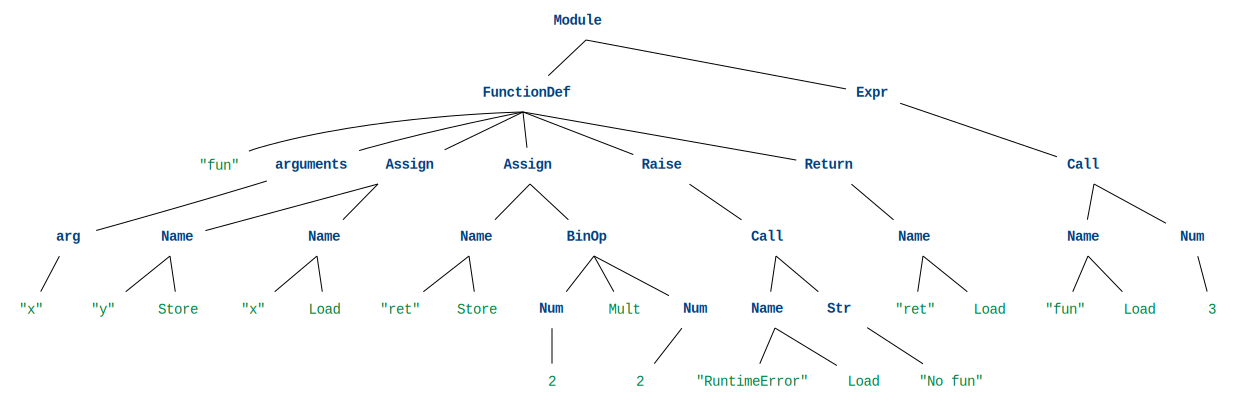

In [112]:
show_ast(fun_tree)

We obtain and manipulate the AST through the Python modules `ast` and `astor`. The [official Python `ast` reference](http://docs.python.org/3/library/ast) is complete, but a bit brief; the documentation ["Green Tree Snakes - the missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/) provides an excellent introduction.

In [113]:
from ast import NodeTransformer, NodeVisitor, fix_missing_locations

In [114]:
class NodeCollector(NodeVisitor):
    """Collect all nodes in an AST in the attributes all_nodes."""
    def __init__(self):
        super().__init__()
        self._all_nodes = []

    def visit(self, node):
        self._all_nodes.append(node)
        return self.generic_visit(node)
    
    def collect(self, tree):
        self._all_nodes = []
        self.generic_visit(tree)
        return self._all_nodes

In [115]:
fun_nodes = NodeCollector().collect(fun_tree)
fun_nodes

In [116]:
class NodeDeleter(NodeTransformer):
    def __init__(self):
        super().__init__()
        self._delete_list = []

    def visit(self, node):
        if node in self._delete_list:
            return None  # delete it
        return self.generic_visit(node)
    
    def delete(self, tree, delete_list):
        self._delete_list = delete_list
        return self.generic_visit(tree)

#### Mark and copy

In [117]:
class NodeMarker(NodeVisitor):
    def visit(self, node):
        # print("Marking", node)
        node.marked = True
        return self.generic_visit(node)

In [118]:
class DeleteMarked(NodeTransformer):
    def visit(self, node):
        if node.marked:
            # print("Deleting", node)
            return None  # delete it
        return self.generic_visit(node)

In [119]:
import copy

In [120]:
def copy_and_delete(tree, keep_list=None):
    if keep_list is None:
        keep_list = []
    NodeMarker().generic_visit(tree)
    for node in keep_list:
        # print("Clearing", node)
        node.marked = False
    new_tree = copy.deepcopy(tree)
    DeleteMarked().generic_visit(new_tree)
    return new_tree

In [121]:
fun_nodes[3]

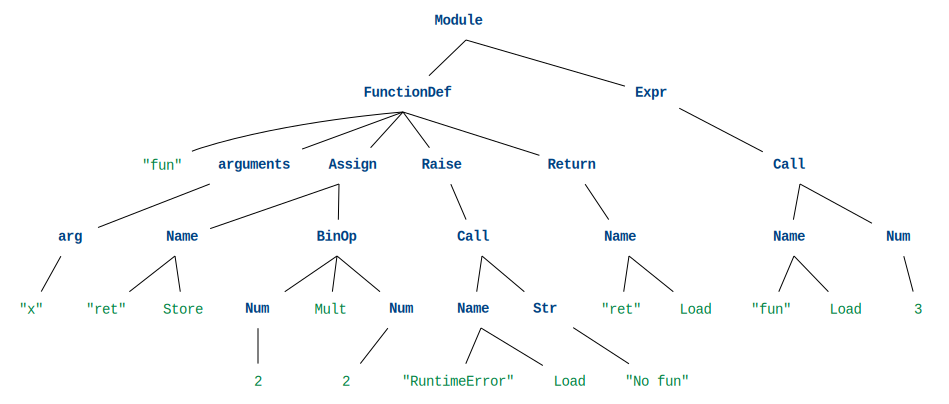

In [122]:
new_fun_tree = copy_and_delete(fun_tree, fun_nodes[:3] + fun_nodes[4:])
show_ast(new_fun_tree)

In [123]:
print_content(astor.to_source(new_fun_tree), '.py')

def fun(x):
    ret = 2 * 2
    raise RuntimeError('No fun')
    return ret


fun(3)

In [124]:
fun_code = compile(new_fun_tree, "<string>", 'exec')

In [125]:
with ExpectError():
    exec(fun_code)

Traceback (most recent call last):
  File "<ipython-input-125-286cf7d09a79>", line 2, in <module>
    exec(fun_code)
  File "<string>", line 7, in <module>
  File "<string>", line 4, in fun
RuntimeError: No fun (expected)


In [126]:
def compile_and_test_ast(tree, keep_list):
    new_tree = copy_and_delete(tree, keep_list)
    try:
        code_object = compile(new_tree, '<string>', 'exec')
    except Exception:
        raise SyntaxError("Cannot compile")

    exec(code_object, {}, {})

In [127]:
with ExpectError():
    compile_and_test_ast(fun_tree, fun_nodes)

Traceback (most recent call last):
  File "<ipython-input-127-7a36be7d7fca>", line 2, in <module>
    compile_and_test_ast(fun_tree, fun_nodes)
  File "<ipython-input-126-d269acb583d3>", line 8, in compile_and_test_ast
    exec(code_object, {}, {})
  File "<string>", line 7, in <module>
  File "<string>", line 4, in fun
RuntimeError: No fun (expected)


In [128]:
with DeltaDebugger() as dd:
    compile_and_test_ast(fun_tree, fun_nodes)

In [129]:
reduced_nodes = dd.reduced_args()['keep_list']
reduced_nodes

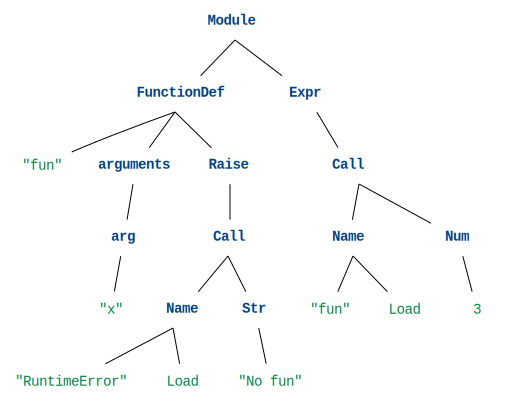

In [130]:
reduced_fun_tree = copy_and_delete(fun_tree, reduced_nodes)
show_ast(reduced_fun_tree)

In [131]:
print_content(astor.to_source(reduced_fun_tree), '.py')

def fun(x):
    raise RuntimeError('No fun')


fun(3)

Success! We have eliminated all nodes from the tree that are irrelevant for the failure.